In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [40]:
# PARAMETERS
STEPS = 500
DT = 1.0 / STEPS
BATCH_SIZE = 128
ITERS = 500
LAMBDA_REG = 0.005 # Regularization weight for control effort

In [41]:
# The Experts (or the pretrained drifts)
def drift_prior_1(x):
    return -1.0 * (x - (-5.0))

def drift_prior_2(x):
    return -1.0 * (x - 5.0)

In [42]:
class ControlNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, x, t):
        xt = torch.cat([x, t], dim=1)
        return self.net(xt)

In [ ]:
# Initialize Control Networks
ctrl1 = ControlNetwork()
ctrl2 = ControlNetwork()
# Combine parameters of both control networks for joint optimization
optimizer = optim.Adam(list(ctrl1.parameters()) + list(ctrl2.parameters()), lr=0.005)

# TRAINING LOOP - SOC VIA BACKPROPAGATION THROUGH TIME
print("Starting training...")
loss_history = []
for epoch in range(ITERS):
    optimizer.zero_grad()
    
    x1 = torch.randn(BATCH_SIZE, 1)
    x2 = torch.randn(BATCH_SIZE, 1)    
    running_control_cost = 0.0
    control_cost = 0.0

    # Simulate Trajectory (Forward Pass)
    for i in range(STEPS):
        t_val = i * DT
        t_tensor = torch.full((BATCH_SIZE, 1), t_val)
        # Get Control from Networks
        u1 = ctrl1(x1, t_tensor)
        u2 = ctrl2(x2, t_tensor)
        # Get Drift from Prior Experts
        b1 = drift_prior_1(x1)
        b2 = drift_prior_2(x2)
        # SDE Update (Euler-Maruyama)
        noise = torch.randn(BATCH_SIZE, 1) * np.sqrt(DT)
        # Dynamics: dX = (drift + contorol)dt + dW
        x1 = x1 + (b1 + u1) * DT + noise
        x2 = x2 + (b2 + u2) * DT + (torch.randn_like(x1) * np.sqrt(DT))
        # Accumulate Running Cost (Control Effort)
        control_cost += torch.mean(u1**2 + u2**2) * DT
        running_control_cost += torch.mean((x1 - x2)**2) * DT

    # Terminal Cost (The Constraint)
    terminal_distance_loss = torch.mean((x1 - x2)**2)
    # Total Loss
    loss = terminal_distance_loss + (LAMBDA_REG * control_cost) + running_control_cost
    # Backward & Update
    loss.backward()
    optimizer.step()
    
    loss_history.append(loss.item())
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss {loss.item():.4f} (Dist: {terminal_distance_loss.item():.4f})")

print("--- Training Complete ---")

Starting training...
Epoch 0: Loss 54.9730 (Dist: 37.8968)
Epoch 100: Loss 0.7793 (Dist: 0.1002)
Epoch 200: Loss 0.6240 (Dist: 0.0824)
Epoch 300: Loss 0.6192 (Dist: 0.0650)
Epoch 400: Loss 0.6282 (Dist: 0.0523)
--- Training Complete ---


In [ ]:
def generate_trajectories(n_paths=100, controlled=True):
    ctrl1.eval()
    ctrl2.eval()
    
    # Storage for plotting
    path_hist_1 = np.zeros((n_paths, STEPS + 1))
    path_hist_2 = np.zeros((n_paths, STEPS + 1))
    
    with torch.no_grad():
        x1 = torch.randn(n_paths, 1)
        x2 = torch.randn(n_paths, 1)
        
        path_hist_1[:, 0] = x1.flatten().numpy()
        path_hist_2[:, 0] = x2.flatten().numpy()
        
        for i in range(STEPS):
            t_val = i * DT
            t_tensor = torch.full((n_paths, 1), t_val)
            
            b1 = drift_prior_1(x1)
            b2 = drift_prior_2(x2)
            
            if controlled:
                u1 = ctrl1(x1, t_tensor)
                u2 = ctrl2(x2, t_tensor)
            else:
                u1 = 0
                u2 = 0
            
            noise1 = torch.randn(n_paths, 1) * np.sqrt(DT)
            noise2 = torch.randn(n_paths, 1) * np.sqrt(DT)
            
            x1 = x1 + (b1 + u1) * DT + noise1
            x2 = x2 + (b2 + u2) * DT + noise2
            
            path_hist_1[:, i+1] = x1.flatten().numpy()
            path_hist_2[:, i+1] = x2.flatten().numpy()
            
    return path_hist_1, path_hist_2
# Generate Data
print("Generating uncontrolled paths...")
u_p1, u_p2 = generate_trajectories(n_paths=200, controlled=False)
print("Generating CONTROLLED paths...")
c_p1, c_p2 = generate_trajectories(n_paths=200, controlled=True)

Generating uncontrolled paths...
Generating CONTROLLED paths...


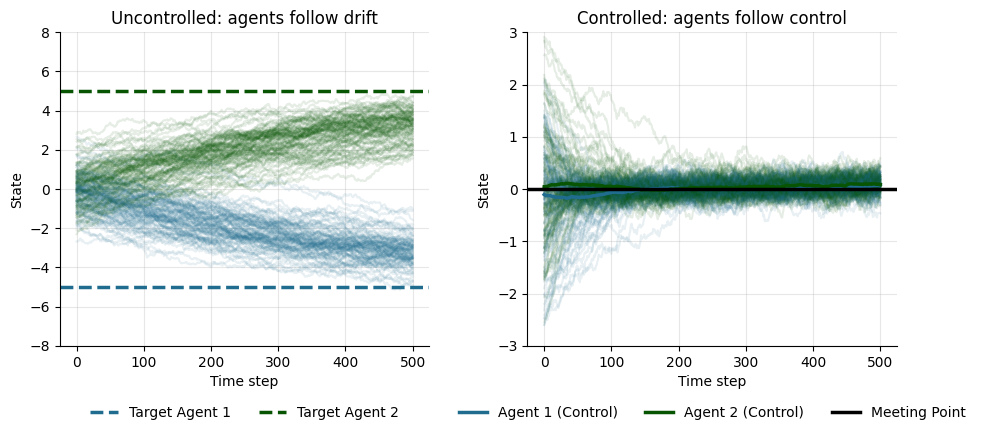

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4.5))

# Pastel colors
color_a1 = "#1f6c8f"
color_a2 = "#075403"

for a in ax:
    a.grid(True, alpha=0.3)
    a.spines["top"].set_visible(False)
    a.spines["right"].set_visible(False)
    a.set_ylim(-8, 8)
    a.set_xlabel("Time step")
    a.set_ylabel("State")

# -------- Plot 1: Uncontrolled (agents follow drift) --------
for i in range(100):
    ax[0].plot(u_p1[i], color=color_a1, alpha=0.1)
    ax[0].plot(u_p2[i], color=color_a2, alpha=0.1)

ax[0].set_title("Uncontrolled: agents follow drift")
ax[0].axhline(-5, color=color_a1, linestyle='--', linewidth=2.5, label='Target Agent 1')
ax[0].axhline(5,  color=color_a2, linestyle='--', linewidth=2.5, label='Target Agent 2')
ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, frameon=False)

# -------- Plot 2: Controlled (agents follow control) --------
for i in range(100):
    ax[1].plot(c_p1[i], color=color_a1, alpha=0.1)
    ax[1].plot(c_p2[i], color=color_a2, alpha=0.1)

ax[1].plot(np.mean(c_p1, axis=0), color=color_a1, linewidth=2.5, label='Agent 1 (Control)')
ax[1].plot(np.mean(c_p2, axis=0), color=color_a2, linewidth=2.5, label='Agent 2 (Control)')
ax[1].set_ylim(-3, 3)

ax[1].set_title("Controlled: agents follow control")
ax[1].axhline(0, color='black', linestyle='-', linewidth=2.5, label='Meeting Point')
ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, frameon=False)

plt.tight_layout()
plt.show()

In [52]:
class ContextAwareControl(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, x, x_mean, t):
        xt = torch.cat([x, x_mean, t], dim=1)
        return self.net(xt)

In [54]:
ctrl1 = ContextAwareControl()
ctrl2 = ContextAwareControl()
optimizer = optim.Adam(list(ctrl1.parameters()) + list(ctrl2.parameters()), lr=0.005)

print(f"--- Starting Training with Aggregate Input ---")
for epoch in range(ITERS):
    optimizer.zero_grad()
    
    x1 = torch.randn(BATCH_SIZE, 1)
    x2 = torch.randn(BATCH_SIZE, 1)
    
    running_control_cost = 0.0
    control_cost = 0.0
    for i in range(STEPS):
        t_val = i * DT
        t_tensor = torch.full((BATCH_SIZE, 1), t_val)
        
        current_mean = (x1 + x2) / 2.0        
        u1 = ctrl1(x1, current_mean, t_tensor)
        u2 = ctrl2(x2, current_mean, t_tensor)
        
        b1 = drift_prior_1(x1)
        b2 = drift_prior_2(x2)
        
        noise1 = torch.randn(BATCH_SIZE, 1) * np.sqrt(DT)
        noise2 = torch.randn_like(noise1) * np.sqrt(DT)
        
        x1 = x1 + (b1 + u1) * DT + noise1
        x2 = x2 + (b2 + u2) * DT + noise2
        
        control_cost += torch.mean(u1**2 + u2**2) * DT
        running_control_cost += torch.mean((x1 - x2)**2) * DT


    loss = torch.mean((x1 - x2)**2) + (LAMBDA_REG * control_cost) + running_control_cost
    
    loss.backward()
    optimizer.step()
    
    if epoch % 200 == 0:
        print(f"Epoch {epoch}: Loss {loss.item():.4f}")

--- Starting Training with Aggregate Input ---
Epoch 0: Loss 61.1026
Epoch 200: Loss 0.5622
Epoch 400: Loss 0.4765


In [ ]:
def generate_coupled_trajectories(n_paths=100):
    ctrl1.eval()
    ctrl2.eval()
    
    path_hist_1 = np.zeros((n_paths, STEPS + 1))
    path_hist_2 = np.zeros((n_paths, STEPS + 1))
    
    with torch.no_grad():
        x1 = torch.randn(n_paths, 1)
        x2 = torch.randn(n_paths, 1)
        
        path_hist_1[:, 0] = x1.flatten().numpy()
        path_hist_2[:, 0] = x2.flatten().numpy()
        
        for i in range(STEPS):
            t_tensor = torch.full((n_paths, 1), i * DT)
            
            current_mean = (x1 + x2) / 2.0
            u1 = ctrl1(x1, current_mean, t_tensor)
            u2 = ctrl2(x2, current_mean, t_tensor)
            
            b1 = drift_prior_1(x1)
            b2 = drift_prior_2(x2)
            
            noise1 = torch.randn(n_paths, 1) * np.sqrt(DT)
            noise2 = torch.randn(n_paths, 1) * np.sqrt(DT)
            
            x1 = x1 + (b1 + u1) * DT + noise1
            x2 = x2 + (b2 + u2) * DT + noise2
            
            path_hist_1[:, i+1] = x1.flatten().numpy()
            path_hist_2[:, i+1] = x2.flatten().numpy()
            
    return path_hist_1, path_hist_2

c_p1, c_p2 = generate_coupled_trajectories(n_paths=200)

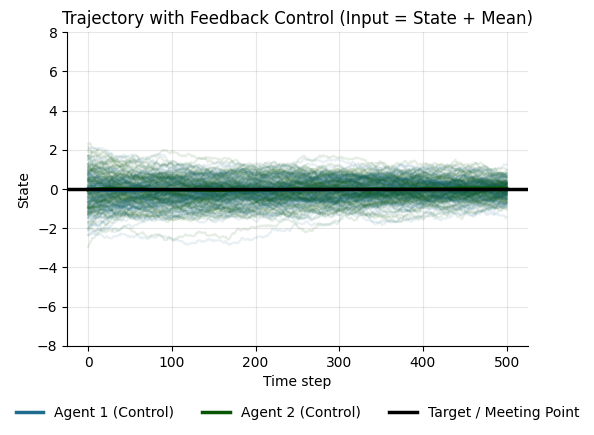

In [ ]:
plt.figure(figsize=(6, 4.5))


color_a1 = "#1f6c8f"
color_a2 = "#075403"

for i in range(100):
    plt.plot(c_p1[i], color=color_a1, alpha=0.1)
    plt.plot(c_p2[i], color=color_a2, alpha=0.1)

plt.plot(np.mean(c_p1, axis=0), color=color_a1, linewidth=2.5, label='Agent 1 (Control)')
plt.plot(np.mean(c_p2, axis=0), color=color_a2, linewidth=2.5, label='Agent 2 (Control)')
plt.axhline(0, color='black', linestyle='-', linewidth=2.5, label='Target / Meeting Point')

plt.ylim(-8, 8)
plt.xlabel("Time step")
plt.ylabel("State")
plt.title("Trajectory with Feedback Control (Input = State + Mean)")

ax = plt.gca()
ax.grid(True, alpha=0.3)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, frameon=False)

plt.tight_layout()
plt.show()